In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import math


In [2]:
# from albumentations import (
#     CLAHE,
#     Blur,
#     OneOf,
#     Compose,
#     RGBShift,
#     GaussNoise,
#     RandomGamma,
#     RandomContrast,
#     RandomBrightness,
# )
from albumentations import Compose
from albumentations.augmentations.transforms import Normalize
from albumentations.pytorch.transforms import ToTensorV2

/home/rahul/.conda/envs/opcv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
from detector import Detector
# from torch.utils.data import DataLoader
# from trainer.datasets import ListDataset

In [4]:
# from trainer.encoder import (
#     DataEncoder,
#     decode_boxes,
#     encode_boxes,
#     generate_anchors,
#     generate_anchor_grid,
# )

In [10]:
class DataEncoder:
    def __init__(self, input_size, classes):
        self.input_size = input_size
        self.anchor_areas = [8 * 8, 16 * 16., 32 * 32., 64 * 64., 128 * 128]  # p3 -> p7
        self.aspect_ratios = [0.5, 1, 2]
        self.scales = [1, pow(2, 1 / 3.), pow(2, 2 / 3.)]
        num_fms = len(self.anchor_areas)
        fm_sizes = [math.ceil(self.input_size[0] / pow(2., i + 3)) for i in range(num_fms)]
        self.anchor_boxes = []
        for i, fm_size in enumerate(fm_sizes):
            anchors = DataEncoder.generate_anchors(self.anchor_areas[i], self.aspect_ratios, self.scales)
            anchor_grid = DataEncoder.generate_anchor_grid(input_size, fm_size, anchors)
            self.anchor_boxes.append(anchor_grid)
        self.anchor_boxes = torch.cat(self.anchor_boxes, 0)
        self.classes = classes

    def encode(self, boxes, classes):
        iou = DataEncoder.compute_iou(boxes, self.anchor_boxes)
        iou, ids = iou.max(1)
        loc_targets = DataEncoder.encode_boxes(boxes[ids], self.anchor_boxes)
        cls_targets = classes[ids]
        cls_targets[iou < 0.5] = -1
        cls_targets[iou < 0.4] = 0

        return loc_targets, cls_targets

    def decode(self, loc_pred, cls_pred, cls_threshold=0.7, nms_threshold=0.3):
        all_boxes = [[] for _ in range(len(loc_pred))]  # batch_size

        for sample_id, (boxes, scores) in enumerate(zip(loc_pred, cls_pred)):
            boxes = DataEncoder.decode_boxes(boxes, self.anchor_boxes)

            conf = scores.softmax(dim=1)
            sample_boxes = [[] for _ in range(len(self.classes))]
            for class_idx, class_name in enumerate(self.classes):
                if class_name == '__background__':
                    continue
                class_conf = conf[:, class_idx]
                ids = (class_conf > cls_threshold).nonzero().squeeze()
                ids = [ids.tolist()]
                keep = DataEncoder.compute_nms(boxes[ids], class_conf[ids], threshold=nms_threshold)

                conf_out, top_ids = torch.sort(class_conf[ids][keep], dim=0, descending=True)
                boxes_out = boxes[ids][keep][top_ids]

                boxes_out = boxes_out.cpu().numpy()
                conf_out = conf_out.cpu().numpy()

                c_dets = np.hstack((boxes_out, conf_out[:, np.newaxis])).astype(np.float32, copy=False)
                c_dets = c_dets[c_dets[:, 4].argsort()]
                sample_boxes[class_idx] = c_dets

            all_boxes[sample_id] = sample_boxes

        return all_boxes

    def get_num_anchors(self):
        return len(self.aspect_ratios) * len(self.scales)
    
    @staticmethod
    def decode_boxes(deltas, anchors):
#         if torch.cuda.is_available():
#             anchors = anchors.cuda()
        anchors_wh = anchors[:, 2:] - anchors[:, :2] + 1
        anchors_ctr = anchors[:, :2] + 0.5 * anchors_wh
        pred_ctr = deltas[:, :2] * anchors_wh + anchors_ctr
        pred_wh = torch.exp(deltas[:, 2:]) * anchors_wh
        return torch.cat([pred_ctr - 0.5 * pred_wh, pred_ctr + 0.5 * pred_wh - 1], 1)

    @staticmethod
    def encode_boxes(boxes, anchors):
        anchors_wh = anchors[:, 2:] - anchors[:, :2] + 1
        anchors_ctr = anchors[:, :2] + 0.5 * anchors_wh
        boxes_wh = boxes[:, 2:] - boxes[:, :2] + 1
        boxes_ctr = boxes[:, :2] + 0.5 * boxes_wh
        return torch.cat([(boxes_ctr - anchors_ctr) / anchors_wh, torch.log(boxes_wh / anchors_wh)], 1)

    @staticmethod
    def generate_anchor_grid(input_size, fm_size, anchors):
        grid_size = input_size[0] / fm_size
        x, y = torch.meshgrid(torch.arange(0, fm_size) * grid_size, torch.arange(0, fm_size) * grid_size)
        anchors = anchors.view(-1, 1, 1, 4)
        xyxy = torch.stack([x, y, x, y], 2).float()
        boxes = (xyxy + anchors).permute(2, 1, 0, 3).contiguous().view(-1, 4)
        boxes[:, 0::2] = boxes[:, 0::2].clamp(0, input_size[0])
        boxes[:, 1::2] = boxes[:, 1::2].clamp(0, input_size[1])
        return boxes

    @staticmethod
    def generate_anchors(anchor_area, aspect_ratios, scales):
        anchors = []
        for scale in scales:
            for ratio in aspect_ratios:
                h = round(math.sqrt(anchor_area) / ratio)
                w = round(ratio * h)
                x1 = (math.sqrt(anchor_area) - scale * w) * 0.5
                y1 = (math.sqrt(anchor_area) - scale * h) * 0.5
                x2 = (math.sqrt(anchor_area) + scale * w) * 0.5
                y2 = (math.sqrt(anchor_area) + scale * h) * 0.5
                anchors.append([x1, y1, x2, y2])
        return torch.Tensor(anchors)

    @staticmethod
    def compute_iou(src, dst):
        p1 = torch.max(dst[:, None, :2], src[:, :2])
        p2 = torch.min(dst[:, None, 2:], src[:, 2:])
        inter = torch.prod((p2 - p1 + 1).clamp(0), 2)
        src_area = torch.prod(src[:, 2:] - src[:, :2] + 1, 1)
        dst_area = torch.prod(dst[:, 2:] - dst[:, :2] + 1, 1)
        iou = inter / (dst_area[:, None] + src_area - inter)
        return iou

    @staticmethod
    def compute_nms(boxes, conf, threshold=0.5):
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        _, order = conf.sort(0, descending=True)

        keep = []
        while order.numel() > 0:
            i = order[0] if order.numel() > 1 else order.item()
            keep.append(i)

            if order.numel() == 1:
                break

            xx1 = x1[order[1:]].clamp(min=x1[i].item())
            yy1 = y1[order[1:]].clamp(min=y1[i].item())
            xx2 = x2[order[1:]].clamp(max=x2[i].item())
            yy2 = y2[order[1:]].clamp(max=y2[i].item())

            w = (xx2 - xx1 + 1).clamp(min=0)
            h = (yy2 - yy1 + 1).clamp(min=0)
            inter = w * h
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

            ids = (ovr <= threshold).nonzero().squeeze()
            if ids.numel() == 0:
                break
            order = order[ids + 1]
        return torch.LongTensor(keep)

In [11]:
class road_scene_detection(object):
    
    def __init__(self, model_path, input_size, classes, device_name = 'cpu'):
        
        self.model_path = model_path
        self.classes = classes
        self.input_size = input_size
        
        self.encoder = DataEncoder(self.input_size, self.classes)
        self.transform = Compose([Normalize(), ToTensorV2()])
        self.device = self.configure_device(device_name)
        self.load_model()
        
    def configure_device(self, device_name):
        self.device = torch.device(device_name)
        
    def load_model(self):
        self.model = Detector(len(self.classes))
        self.model.load_state_dict(
                        torch.load(self.model_path)
                    )
        self.model = self.model.eval()
        self.model.to(self.device)
        
    def transform_image(self, img):
        img = img[..., ::-1]
        img = cv2.resize(img, self.input_size)
        img = np.array(img)
        img = self.transform(image=img)['image']
        return img
    
    def transform_detections(self, loc_preds, cls_preds):
        with torch.no_grad():
            samples = self.encoder.decode(loc_preds, cls_preds)
        return samples
            
    def predict(self, img_path):
        img = cv2.imread(img_path)
        img_orig = np.array(img)
        img = self.transform_image(img)
        img = img.to(self.device)
        loc_preds, cls_preds = self.model(img.unsqueeze(0))
        detections = self.transform_detections(loc_preds, cls_preds)
        return detections
        

In [12]:
classes=[
    "__background__",
    "biker",
    "car",
    "pedestrian",
    "trafficLight",
    "trafficLight-Green",
    "trafficLight-GreenLeft",
    "trafficLight-Red",
    "trafficLight-RedLeft",
    "trafficLight-Yellow",
    "trafficLight-YellowLeft",
    "truck"
]

model_path = "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/checkpoints/Detector_best.pth"
root_dir = "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Datasets/Road_Scene_Object_Detection/export"
file_name = "1478732741316067783_jpg.rf.bd19503e85e0a6169720bc906e6a4a51.jpg"
image_path = os.path.join(root_dir, file_name)

input_size = (300,300)

In [13]:
detector_ssd = road_scene_detection(model_path, input_size, classes)

In [15]:
detections = detector_ssd.predict(image_path)

In [20]:
for cls_id, detection in enumerate(detections[0]):
    print(detection)

[]
[[ 86.84688    143.57478     95.866196   157.93639      0.99945277]
 [142.23792    141.0783     152.4426     154.76305      0.999949  ]
 [ 77.45625    140.87561     88.01344    157.00665      0.99999166]
 [104.20627    138.26292    114.979904   156.18242      0.99999774]
 [158.05145    141.23929    168.90692    157.27475      1.        ]
 [ 48.442204   141.97955     63.729584   154.58136      1.        ]]
[]
[]
[]
[]
[]
[]
[]
[]
[[ 70.117355 139.54929   79.068924 155.11371    0.984018]]
[]


In [10]:
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

std = torch.Tensor(std)
mean = torch.Tensor(mean)

In [11]:
# transform=Compose([Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), ToTensorV2()])
transform=Compose([Normalize(), ToTensorV2()])

In [12]:
img = cv2.imread(os.path.join(root_dir, file_name))
img = img[..., ::-1]
img_orig = np.array(img)
img = cv2.resize(img, (300, 300))

img = np.array(img)

img = transform(image=img)['image']

In [13]:
img.device

device(type='cpu')

In [10]:
img.shape

torch.Size([3, 300, 300])

In [11]:
img_orig.shape

(1200, 1920, 3)

In [13]:
device = torch.device("cuda")
img = img.to(device).clone()

model = Detector(len(classes))
model_path = "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/checkpoints/Detector_best.pth"
model.load_state_dict(
                torch.load(model_path)
            )
model = model.eval()
model.to(device)

Detector(
  (fpn): FPN(
    (feature_extractor): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [14]:
loc_preds, cls_preds = model(img.unsqueeze(0))

In [15]:
with torch.no_grad():
    encoder = DataEncoder((300, 300))
    samples = encoder.decode(loc_preds, cls_preds)
    c_dets = samples[0][1]  # detections for class == 2

/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/SSD_Trainer/trainer/encoder.py:58: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  ids = (class_conf > cls_threshold).nonzero().squeeze()


In [16]:
boxes = c_dets[:, :4]

In [17]:
1920/300, 1200/300

(6.4, 4.0)

In [18]:
for box in boxes:
    box[0] = int(box[0]*6.4)
    box[1] = int(box[1]*4)
    box[2] = int(box[2]*6.4)
    box[3] = int(box[3]*4)

In [19]:
boxes

array([[ 555.,  574.,  613.,  631.],
       [ 910.,  564.,  975.,  619.],
       [ 495.,  563.,  563.,  628.],
       [ 666.,  553.,  735.,  624.],
       [ 310.,  567.,  407.,  618.],
       [ 999.,  566., 1067.,  630.]], dtype=float32)

In [20]:
for box in boxes:
    xmin = int(box[0])
    ymin = int(box[1])
    xmax = int(box[2])
    ymax = int(box[3])
    img_orig = cv2.rectangle(
            img_orig, (xmin, ymin), (xmax, ymax), (0, 255, 0),4
        )

In [21]:
type(img_orig)

numpy.ndarray

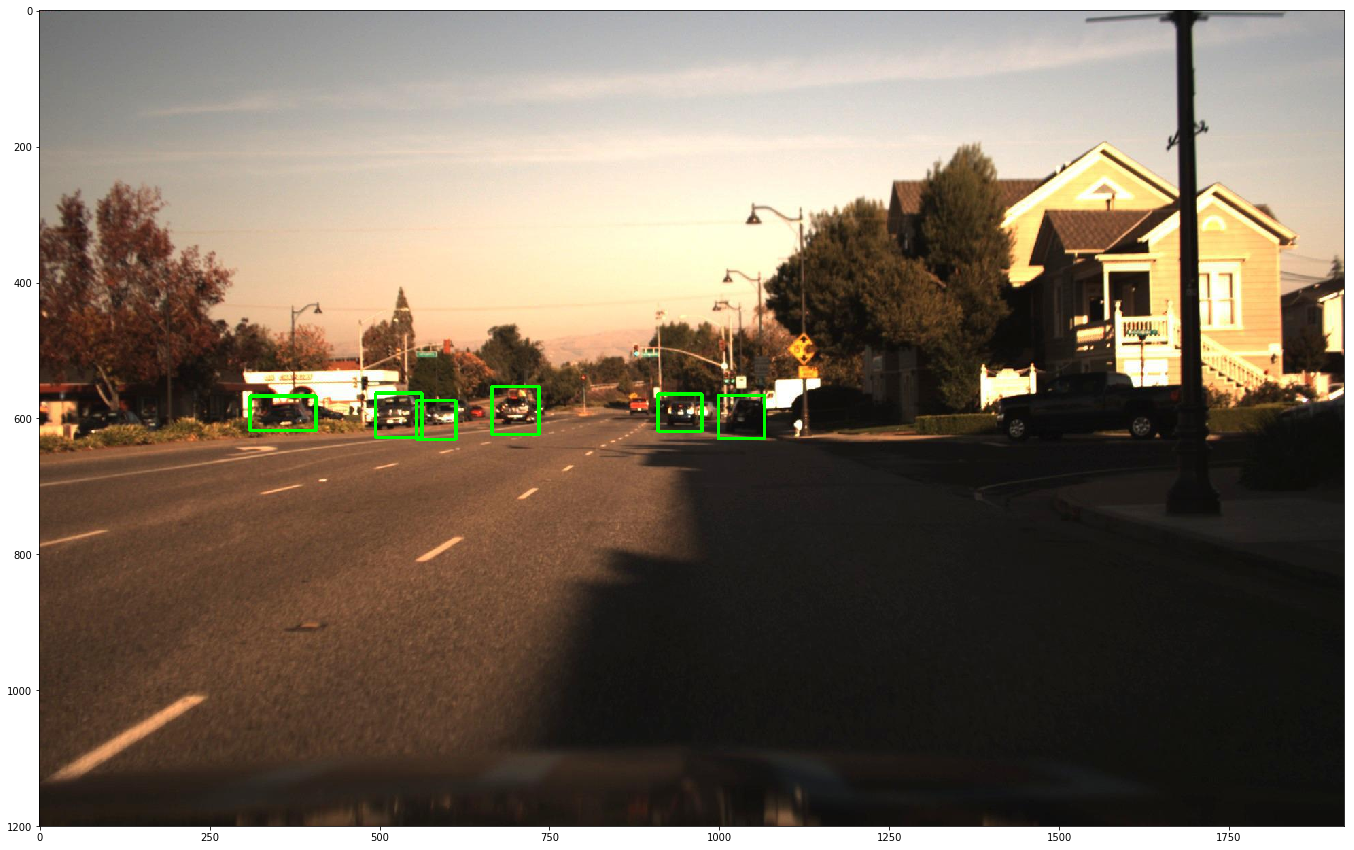

In [22]:
plt.figure(figsize = (24,15))
plt.imshow(img_orig)
plt.show()

In [10]:
# dataset_test = ListDataset(
#     root_dir="../../../Datasets/Road_Scene_Object_Detection",
#     data_dir = 'export',
#     list_file='annots_one_example.txt',
#     classes=[
#         "__background__",
#         "biker",
#         "car",
#         "pedestrian",
#         "trafficLight",
#         "trafficLight-Green",
#         "trafficLight-GreenLeft",
#         "trafficLight-Red",
#         "trafficLight-RedLeft",
#         "trafficLight-Yellow",
#         "trafficLight-YellowLeft",
#         "truck"
#     ],
#     mode='val',
#     transform=Compose([Normalize(), ToTensorV2()]),
#     input_size=300
# )
# loader_test = DataLoader(
#     dataset=dataset_test,
#     batch_size=32,
#     shuffle=False,
#     collate_fn=dataset_test.collate_fn,
#     num_workers=5,
#     pin_memory=True
# )

In [11]:
index = random.randrange(len(loader_test.dataset))

In [12]:
image, gt_boxes, _ = loader_test.dataset[index]

In [13]:
image[0,:,:]

tensor([[ 0.3138, -0.1828, -0.0287,  ...,  0.6734,  0.7077,  0.6392],
        [-0.3198, -0.2856, -0.2342,  ...,  0.7248,  0.6734,  0.6734],
        [-0.2171, -0.1657, -0.1828,  ...,  0.7248,  0.7077,  0.7077],
        ...,
        [-1.5528, -1.5014, -1.5014,  ..., -1.8610, -1.8610, -1.8610],
        [-1.5699, -1.5185, -1.4843,  ..., -1.8610, -1.8610, -1.8610],
        [-1.5699, -1.5185, -1.4843,  ..., -1.8610, -1.8610, -1.8610]])

In [14]:
img[0,:,:]

tensor([[ 0.3138, -0.1828, -0.0287,  ...,  0.6734,  0.7077,  0.6392],
        [-0.3198, -0.2856, -0.2342,  ...,  0.7248,  0.6734,  0.6734],
        [-0.2171, -0.1657, -0.1828,  ...,  0.7248,  0.7077,  0.7077],
        ...,
        [-1.5528, -1.5014, -1.5014,  ..., -1.8610, -1.8610, -1.8610],
        [-1.5699, -1.5185, -1.4843,  ..., -1.8610, -1.8610, -1.8610],
        [-1.5699, -1.5185, -1.4843,  ..., -1.8610, -1.8610, -1.8610]])

In [17]:
image[0,:,:] == img[0,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [18]:
image[1,:,:] == img[1,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [19]:
image[2,:,:] == img[2,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [11]:
image = img.clone()

In [13]:
device = torch.device("cuda")
image = image.to(device).clone()

In [14]:
model = Detector(len(classes))
model_path = "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/checkpoints/Detector_best.pth"
model.load_state_dict(
                torch.load(model_path)
            )
model = model.eval()

In [15]:
# std = (0.229, 0.224, 0.225)
# mean = (0.485, 0.456, 0.406)

# std = torch.Tensor(std)
# mean = torch.Tensor(mean)

In [16]:
model.to(device)

Detector(
  (fpn): FPN(
    (feature_extractor): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [15]:
device

device(type='cuda')

In [17]:
loc_preds, cls_preds = model(image.unsqueeze(0))

In [18]:
cls_preds, loc_preds

(tensor([[[ 25.5282,  -0.7378,  -1.7065,  ...,  -2.9748,  -0.7462,  -7.3740],
          [ 23.4503,   0.0498,   0.1511,  ...,  -5.2889,  -4.7883,  -6.2766],
          [ 23.4513,  -0.6018,   0.9033,  ...,  -3.7070,  -3.7639,  -4.0563],
          ...,
          [ 45.7296,  18.3862,  13.2742,  ...,  -9.5562,  -3.1632, -13.4385],
          [ 38.0442,  22.6829,   6.0351,  ...,  -9.3336, -15.3055,  -8.7820],
          [ 35.4958,  10.3395,   4.5152,  ...,  -3.6903,  -4.0664,  -5.8884]]],
        device='cuda:0', grad_fn=<CatBackward>),
 tensor([[[-0.0076,  0.0060, -0.2925,  0.0731],
          [-0.0368, -0.0409, -0.4171,  0.1064],
          [-0.0805, -0.1495, -0.4031,  0.3859],
          ...,
          [-0.0097,  0.1440, -0.1165, -0.1498],
          [ 0.0236,  0.0266, -0.4046, -0.0768],
          [-0.0163, -0.0376, -0.3107,  0.0629]]], device='cuda:0',
        grad_fn=<CatBackward>))

In [22]:
with torch.no_grad():
    img = image.cpu()
    img.mul_(std[:, None, None]).add_(mean[:, None, None])
    img = torch.clamp(img, min=0.0, max=1.0)
    img = img.numpy().transpose(1, 2, 0)

    img = (img * 255.).astype(np.uint8)
    gt_img = img.copy()
    pred_img = img.copy()

#     for box in gt_boxes:
#         gt_img = cv2.rectangle(
#             gt_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0),
#             thickness=2
#         )

    encoder = DataEncoder((img.shape[1], img.shape[0]))
    samples = encoder.decode(loc_preds, cls_preds)
    c_dets = samples[0][1]  # detections for class == 2

    if c_dets.size > 0:
        boxes = c_dets[:, :4]
        for box in boxes:
            pred_img = cv2.rectangle(
                pred_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255),
                thickness=2
            )

In [23]:
samples[0]

[[], array([[ 86.84688   , 143.57478   ,  95.866196  , 157.93639   ,
           0.99945277],
        [142.23792   , 141.0783    , 152.4426    , 154.76305   ,
           0.999949  ],
        [ 77.45626   , 140.87563   ,  88.01345   , 157.00667   ,
           0.99999166],
        [104.206276  , 138.26292   , 114.97991   , 156.18242   ,
           0.99999774],
        [ 48.442204  , 141.97954   ,  63.729576  , 154.58134   ,
           1.        ],
        [156.24225   , 141.67589   , 166.74286   , 157.52211   ,
           1.        ]], dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([[ 70.117355, 139.5493  ,  79.068924, 155.11372 ,   0.984018]],
       dtype=float32), array([], shape=(0, 5), dtype=fl

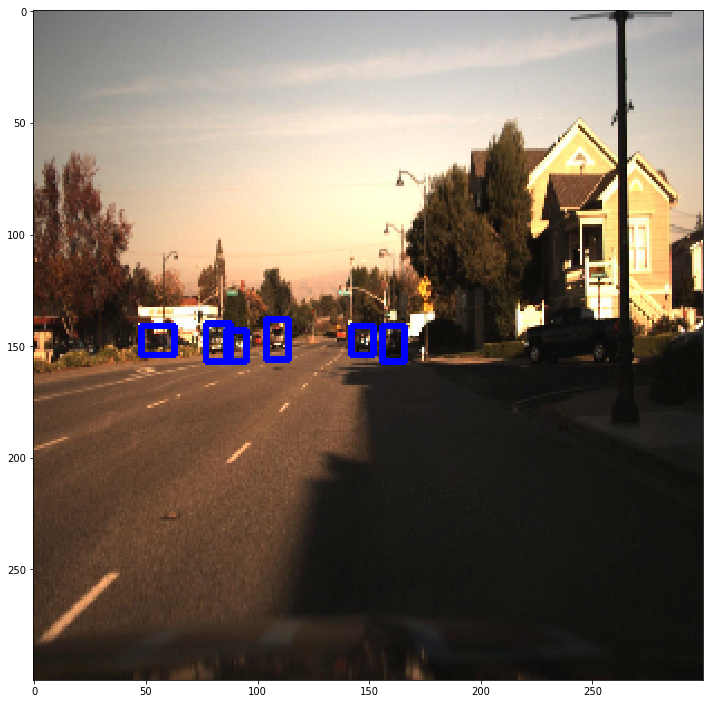

In [21]:
plt.figure(figsize = (12,18))
plt.imshow(pred_img)
plt.show()

In [21]:
pred_img.shape

(300, 300, 3)

In [24]:
loc_preds.shape

torch.Size([1, 17451, 4])

In [25]:
cls_preds.shape

torch.Size([1, 17451, 12])

In [27]:
with torch.no_grad():
    encoder = DataEncoder((img.shape[1], img.shape[0]))
    samples = encoder.decode(loc_preds, cls_preds)
    c_dets = samples[0][1]  # detections for class == 2

In [30]:
len(samples)

[[[], array([[110.194984  , 150.10185   , 119.505806  , 172.12743   ,
            0.999998  ],
         [112.916466  , 147.03416   , 129.5961    , 176.91158   ,
            0.99999857],
         [ 55.951195  , 151.40337   ,  72.62675   , 172.70732   ,
            0.9999999 ],
         [ 76.975105  , 141.93071   , 115.54575   , 190.94228   ,
            1.        ],
         [ 30.006063  , 151.71124   ,  49.907722  , 179.16592   ,
            1.        ],
         [127.60211   , 142.22128   , 148.33496   , 180.72037   ,
            1.        ],
         [171.16089   , 142.92197   , 230.50882   , 196.19022   ,
            1.        ],
         [  0.7825365 , 156.03766   ,  13.830743  , 187.46606   ,
            1.        ],
         [147.66019   , 131.95633   , 179.2555    , 188.75897   ,
            1.        ]], dtype=float32), array([[243.68504  , 143.28922  , 254.41603  , 179.66394  ,   0.8289954],
         [228.26013  , 144.02376  , 236.94553  , 174.65019  ,   0.9153588]],
        d